In [ ]:
%pip install pydicom matplotlib ipywidgets tqdm ipympl scipy scikit-image opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [81]:
%matplotlib widget

In [45]:
import os
import numpy as np
import pydicom
from tqdm import tqdm
import cv2

# Base dataset path (relative to the script location)
BASE_PATH = "project-3-data"

def is_dicom_file(filepath):
    """Checks if a file is a valid DICOM file by reading its header."""
    try:
        if "DIRFILE" in filepath:  # Explicitly ignore DIRFILE
            return False
        pydicom.dcmread(filepath, stop_before_pixels=True)
        return True
    except:
        return False

def clahe_equalization(volume, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to a 3D volume slice-by-slice.

    Args:
    - volume: The 3D volume (raw CT scan).
    - clip_limit: The contrast limit for CLAHE.
    - tile_grid_size: The size of grid for CLAHE.

    Returns:
    - equalized_volume: The processed volume after CLAHE.
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    equalized_volume = np.zeros_like(volume, dtype=np.uint8)

    for i in range(volume.shape[-1]):
        slice_ = volume[..., i]

        # Convert the slice to 8-bit before applying CLAHE
        slice_8bit = np.uint8(np.interp(slice_, (slice_.min(), slice_.max()), (0, 255)))

        equalized_volume[..., i] = clahe.apply(slice_8bit)

    return equalized_volume

def z_score_normalization(volume):
    """
    Normalize the volume using Z-score normalization.

    Args:
    - volume: The 3D volume to be normalized.

    Returns:
    - normalized_volume: The normalized volume (Z-score).
    """
    mean = np.mean(volume)
    std = np.std(volume)
    normalized_volume = (volume - mean) / std
    return normalized_volume

def histogram_equalization_and_denoising(volume, apply_denoising=True):
    """
    Apply CLAHE and optional denoising to the volume.

    Args:
    - volume: The 3D volume (raw CT scan).
    - apply_denoising: If True, apply denoising after CLAHE.

    Returns:
    - processed_volume: The processed volume after CLAHE and denoising.
    """
    # Apply CLAHE first for contrast enhancement
    equalized_volume = clahe_equalization(volume)

    # Apply denoising (optional)
    if apply_denoising:
        denoised_volume = np.zeros_like(equalized_volume, dtype=np.uint8)
        for i in range(equalized_volume.shape[-1]):
            slice_ = equalized_volume[..., i]
            denoised_volume[..., i] = cv2.fastNlMeansDenoising(slice_, h=10, templateWindowSize=7, searchWindowSize=21)
        return denoised_volume

    return equalized_volume

def load_dicom_series(scan_path):
    """Loads a series of DICOM slices, sorts them, and returns the equalized and denoised volume."""
    dicom_files = []

    for root, _, files in os.walk(scan_path):
        for file in files:
            file_path = os.path.join(root, file)
            if is_dicom_file(file_path):
                dicom_files.append(file_path)

    if len(dicom_files) <= 10:
        return None

    slices = [pydicom.dcmread(f) for f in dicom_files]
    slices.sort(key=lambda x: getattr(x, 'InstanceNumber', getattr(x, 'SliceLocation', 0)))

    # Get pixel data directly
    volume = np.stack([s.pixel_array for s in slices], axis=-1)

    # Apply CLAHE and optional denoising
    processed_volume = histogram_equalization_and_denoising(volume)

    # Apply Z-score normalization for intensity standardization
    normalized_volume = z_score_normalization(processed_volume)

    return normalized_volume

def load_all_patients(base_path):
    """Loads all valid CT scans for all patients into a dictionary (normalized form only)."""
    patient_data = {}
    patient_folders = [
        os.path.join(base_path, patient)
        for patient in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, patient))
    ]
    
    valid_scans = []
    for patient_path in patient_folders:
        for scan in os.listdir(patient_path):
            scan_path = os.path.join(patient_path, scan)
            if os.path.isdir(scan_path):
                dicom_files = [f for f in os.listdir(scan_path) if is_dicom_file(os.path.join(scan_path, f))]
                if len(dicom_files) > 10:
                    valid_scans.append(scan_path)

    for scan_path in tqdm(valid_scans, desc="Loading scans", unit="scan"):
        patient_name = os.path.basename(os.path.dirname(scan_path))
        scan_name = os.path.basename(scan_path)
        key = f"{patient_name}_{scan_name}"
        
        # Load and process the scan
        normalized_volume = load_dicom_series(scan_path)
        if normalized_volume is not None:
            patient_data[key] = normalized_volume
    
    return patient_data

# Load data with progress bar
patient_volumes = load_all_patients(BASE_PATH)
print(f"Loaded {len(patient_volumes)} valid CT scans.")


Loading scans: 100%|██████████| 18/18 [07:51<00:00, 26.20s/scan]

Loaded 18 valid CT scans.


'ROI corner 1 set at: (278, 404, 108)'

'ROI corner 2 set at: (140, 211, 121)'

'ROI bounds set: (140, 278, 211, 404, 108, 121)'

'Seed point set at: (237, 379, 114)'

'Seed point set at: (165, 282, 115)'

'Running segmentation from multiple seeds...'

'Post-processing seed at (237, 379, 114)...'

'Keeping largest component connected to seed (237, 379, 114)...'

'Post-processing seed at (165, 282, 115)...'

'Keeping largest component connected to seed (165, 282, 115)...'

AttributeError: 'NoneType' object has no attribute 'handle_json'

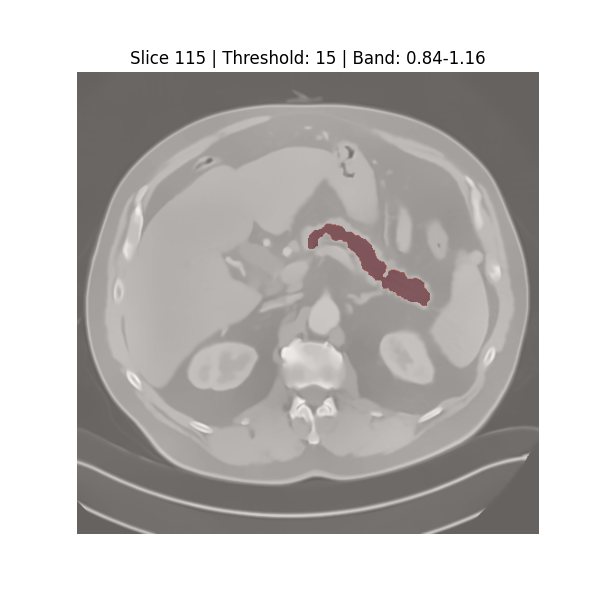

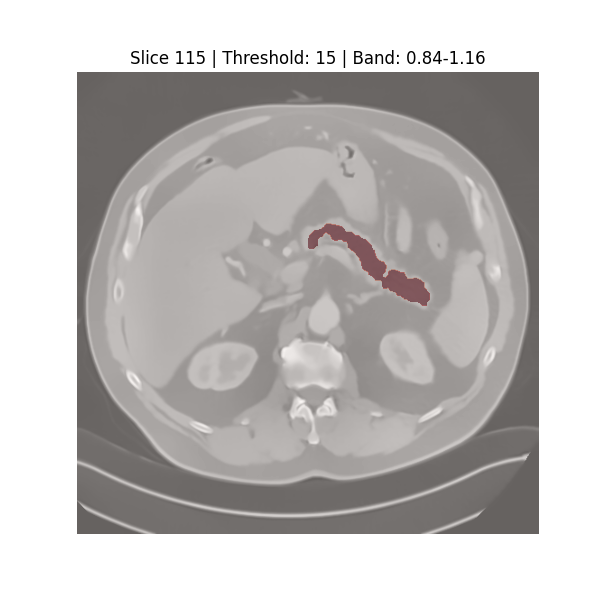

AttributeError: 'NoneType' object has no attribute 'handle_json'

AttributeError: 'NoneType' object has no attribute 'handle_json'

AttributeError: 'NoneType' object has no attribute 'handle_json'

AttributeError: 'NoneType' object has no attribute 'resize'

AttributeError: 'NoneType' object has no attribute 'handle_json'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, Output, VBox, HBox, FloatSlider, Button, IntSlider
from IPython.display import display
from threading import Thread
from scipy.ndimage import binary_fill_holes, binary_closing, binary_opening, label, generate_binary_structure

# Globals
selected_scan_key = None
eq_volume = None
display_volume = None
clicks = []
roi_bounds = None
segmentation_mask = None
bounding_box_set = False
seeds = []
slice_slider = None
image_output = Output()

# Adjustable parameters
params = {
    'intensity_threshold': 20,
    'intensity_band_lower': 0.80,
    'intensity_band_upper': 1.20
}

def render_slice(index):
    with image_output:
        image_output.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(display_volume[:, :, index], cmap="gray")
        if segmentation_mask is not None:
            ax.imshow(segmentation_mask[:, :, index], cmap="Reds", alpha=0.4)
        if segmentation_mask is not None:
            ax.set_title(f"Slice {index} | Threshold: {params['intensity_threshold']:.0f} | Band: {params['intensity_band_lower']:.2f}-{params['intensity_band_upper']:.2f}")
        else:
            ax.set_title(f"Slice {index}")
        ax.axis("off")
        fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()

def update_scan(scan_name):
    global selected_scan_key, eq_volume, display_volume, clicks, segmentation_mask, bounding_box_set, seeds, roi_bounds, slice_slider
    plt.close('all')
    selected_scan_key = scan_name
    eq_volume = patient_volumes[scan_name].copy()
    display_volume = eq_volume.copy()
    segmentation_mask = None
    clicks = []
    roi_bounds = None
    seeds = []
    bounding_box_set = False

    num_slices = eq_volume.shape[-1]

    slice_slider = IntSlider(value=0, min=0, max=num_slices - 1, description="Slice:", continuous_update=False)
    slice_slider.observe(lambda change: render_slice(change['new']), names='value')

    render_slice(0)

    controls_box.children = [
        HBox([param_controls, VBox([slice_slider, start_segmentation_button])]),
        image_output
    ]

def onclick(event):
    global clicks, roi_bounds, bounding_box_set, seeds
    if event.xdata is None or event.ydata is None:
        return

    x = int(event.ydata)
    y = int(event.xdata)
    z = slice_slider.value
    click_point = (x, y, z)
    clicks.append(click_point)

    if len(clicks) == 1:
        display(f"ROI corner 1 set at: {click_point}")
    elif len(clicks) == 2 and not bounding_box_set:
        display(f"ROI corner 2 set at: {click_point}")
        x1, y1, z1 = clicks[0]
        x2, y2, z2 = clicks[1]
        roi_bounds = (
            min(x1, x2), max(x1, x2),
            min(y1, y2), max(y1, y2),
            min(z1, z2), max(z1, z2)
        )
        bounding_box_set = True
        display(f"ROI bounds set: {roi_bounds}")
    elif len(clicks) > 2 and bounding_box_set:
        display(f"Seed point set at: {click_point}")
        seeds.append(click_point)

def dynamic_thresholding_and_neighborhood_analysis(volume, seed, roi_bounds):
    x_min, x_max, y_min, y_max, z_min, z_max = roi_bounds
    segmentation = np.zeros_like(volume, dtype=bool)
    segmentation[seed] = True

    volume_float = volume.astype(np.float32)
    seed_value = float(volume_float[seed])

    threshold = params['intensity_threshold']
    min_intensity = seed_value * params['intensity_band_lower']
    max_intensity = seed_value * params['intensity_band_upper']

    neighbors = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
    active_front = [seed]

    for i in range(250):
        new_front = []
        for point in active_front:
            for dx, dy, dz in neighbors:
                x, y, z = point[0] + dx, point[1] + dy, point[2] + dz
                if (x_min <= x <= x_max and 
                    y_min <= y <= y_max and 
                    z_min <= z <= z_max and
                    not segmentation[x, y, z]):

                    intensity = volume_float[x, y, z]
                    if (min_intensity <= intensity <= max_intensity and
                        abs(intensity - seed_value) <= threshold):

                        segmentation[x, y, z] = True
                        new_front.append((x, y, z))

        if not new_front:
            break
        active_front = new_front

        if i > 10:
            segmented_values = volume_float[segmentation]
            avg_intensity = np.mean(segmented_values)

            initial_margin = (params['intensity_band_upper'] - params['intensity_band_lower']) / 2
            tightened_margin = initial_margin / 2

            min_intensity = avg_intensity * (1 - tightened_margin)
            max_intensity = avg_intensity * (1 + tightened_margin)

    return segmentation.astype(np.uint8) * 255

def gentle_postprocess(mask):
    filled = np.zeros_like(mask, dtype=bool)
    for z in range(mask.shape[2]):
        filled[:, :, z] = binary_fill_holes(mask[:, :, z] > 0)

    structure = generate_binary_structure(3, 1)
    closed = binary_closing(filled, structure=structure, iterations=1)

    return closed.astype(np.uint8) * 255

def keep_largest_component_connected_to_seed(mask, seed):
    opened = binary_opening(mask, structure=np.ones((4, 4, 4)))
    labeled_mask, num_features = label(opened)
    seed_label = labeled_mask[seed]

    if seed_label == 0:
        print("Warning: seed not in any labeled region after opening.")
        return np.zeros_like(mask)

    return (labeled_mask == seed_label).astype(np.uint8) * 255

def create_parameter_controls():
    threshold_slider = FloatSlider(
        value=params['intensity_threshold'],
        min=5,
        max=30,
        step=1,
        description='Threshold:',
        continuous_update=False
    )

    lower_slider = FloatSlider(
        value=params['intensity_band_lower'],
        min=0.70,
        max=0.95,
        step=0.01,
        description='Lower band:',
        continuous_update=False
    )

    upper_slider = FloatSlider(
        value=params['intensity_band_upper'],
        min=1.05,
        max=1.30,
        step=0.01,
        description='Upper band:',
        continuous_update=False
    )

    def update_params(change):
        params['intensity_threshold'] = threshold_slider.value
        params['intensity_band_lower'] = lower_slider.value
        params['intensity_band_upper'] = upper_slider.value

    threshold_slider.observe(update_params, names='value')
    lower_slider.observe(update_params, names='value')
    upper_slider.observe(update_params, names='value')

    return VBox([threshold_slider, lower_slider, upper_slider])

def start_segmentation_button_handler(button):
    if roi_bounds is None:
        display("Please define ROI bounds before segmentation.")
        return

    if len(seeds) == 0:
        display("Please place at least one seed before starting segmentation.")
        return

    try:
        thread = Thread(target=run_segmentation)
        thread.start()
    except Exception as e:
        display(f"Segmentation error: {e}")

def run_segmentation():
    global segmentation_mask
    display("Running segmentation from multiple seeds...")

    combined_segmentation = np.zeros_like(eq_volume, dtype=bool)
    for seed in seeds:
        seg = dynamic_thresholding_and_neighborhood_analysis(eq_volume, seed, roi_bounds)

        display(f"Post-processing seed at {seed}...")
        seg = gentle_postprocess(seg)

        display(f"Keeping largest component connected to seed {seed}...")
        seg = keep_largest_component_connected_to_seed(seg, seed)

        combined_segmentation |= seg > 0

    segmentation_mask = combined_segmentation.astype(np.uint8) * 255
    render_slice(slice_slider.value)

# GUI Setup
param_controls = create_parameter_controls()
start_segmentation_button = Button(description="Start Segmentation")
start_segmentation_button.on_click(start_segmentation_button_handler)

scan_dropdown = Dropdown(
    options=["Select scan"] + list(patient_volumes.keys()),
    description='Scan:',
    value="Select scan"
)

controls_box = VBox([])
output = Output()

def on_scan_select(change):
    if change['new'] == "Select scan":
        return
    with output:
        update_scan(change['new'])

scan_dropdown.observe(on_scan_select, names='value')

display(VBox([
    scan_dropdown,
    controls_box,
    output
]))
